# Surface heat flux movie

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=25)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.1f1c368254204c0e98a83f116b3c86fb/status,


In [74]:
client.close()
cluster.close()

In [4]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
import json

In [5]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [11]:
ds_slt = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/ds_slt_wg_new.zarr'), consolidated=False)
ds_tmp = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/ds_tmp_wg.zarr'), consolidated=False)

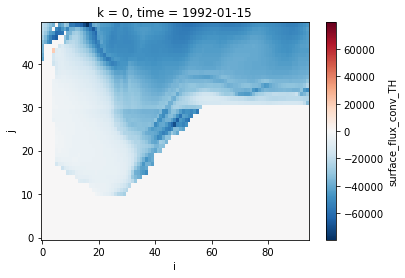

In [12]:
ds_tmp.surface_flux_conv_TH[0,0].plot()

In [13]:
ds_tmp.surface_flux_conv_TH.sel(time=slice('2004', '2008'))

,Array,Chunk
Bytes,54.36 MiB,0.91 MiB
Shape,"(50, 60, 50, 95)","(50, 1, 50, 95)"
Count,349 Tasks,60 Chunks
Type,float32,numpy.ndarray


In [21]:
import xarray as xr
from xmovie import Movie

/srv/conda/envs/notebook/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


/srv/conda/envs/notebook/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


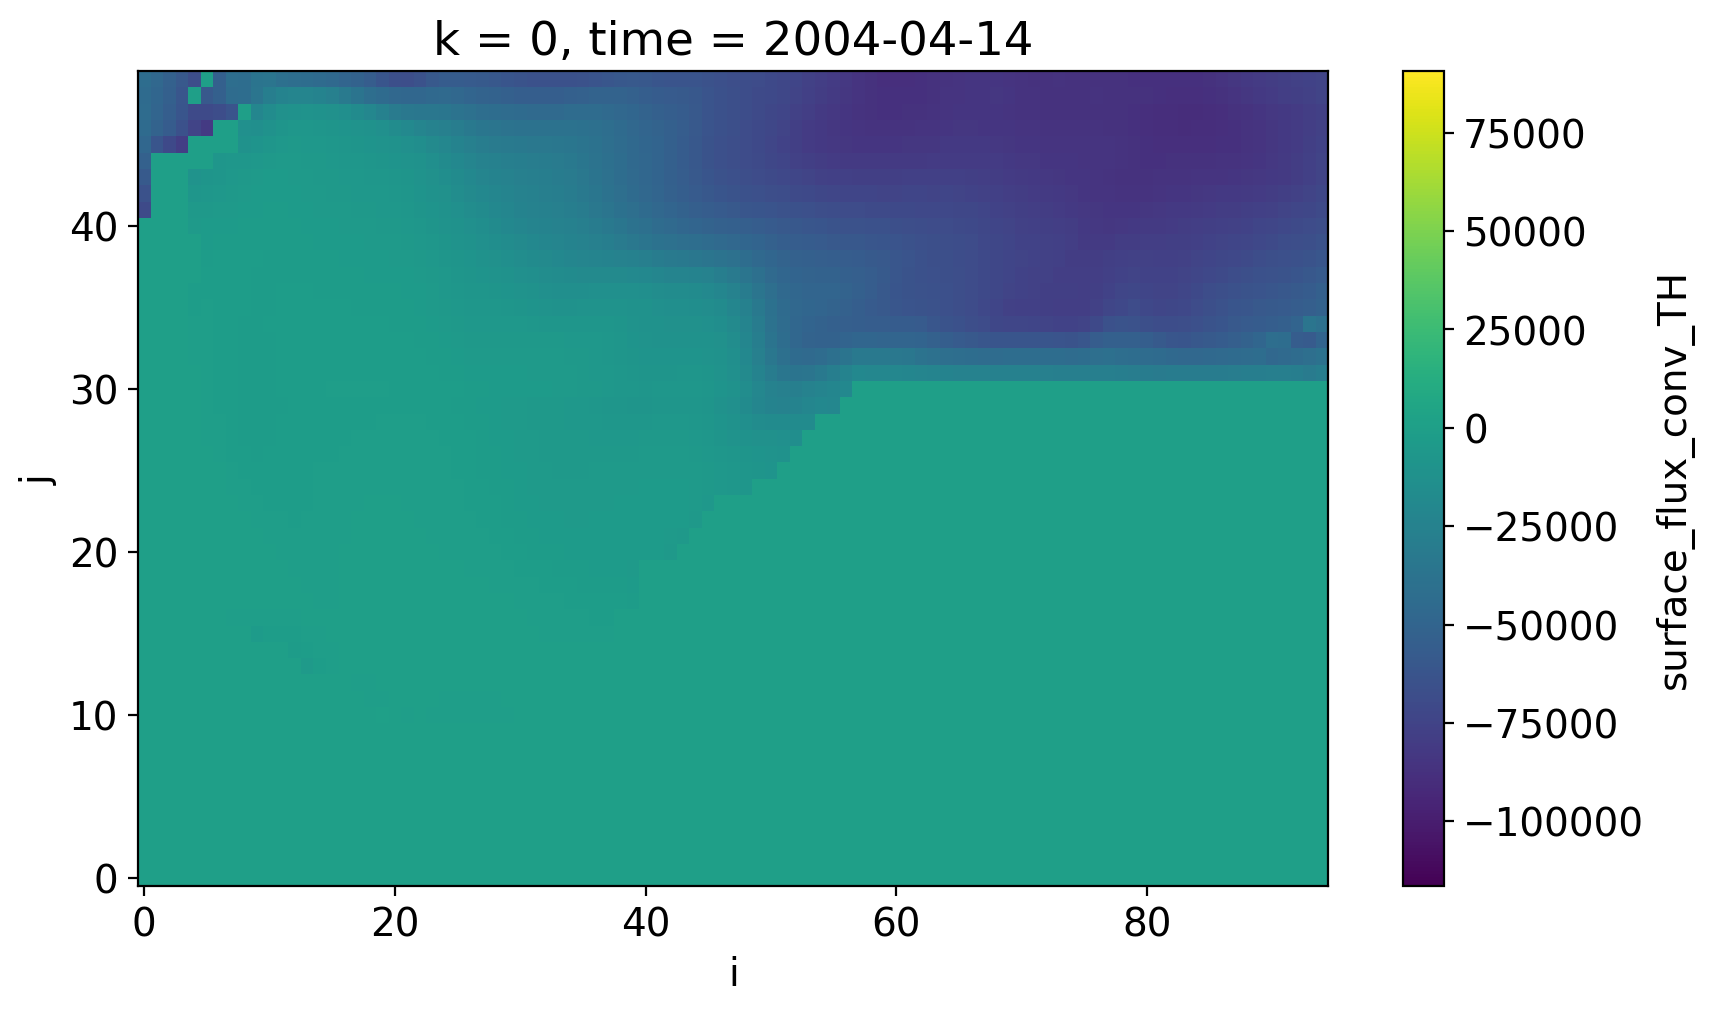

In [28]:
mov = Movie(ds_tmp.surface_flux_conv_TH.sel(time=slice('2004', '2008'), k=0))
mov.preview(3)

In [29]:
#save surf heat flux movie
mov.save('surf_heat_flx_ECCO.mp4', progress=True)

  0%|          | 0/60 [00:00<?, ?it/s]

Movie created at surf_heat_flx_ECCO.mp4


# Surface heat flux without making it 3D variable

In [31]:
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon

In [32]:
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)

ds_ll = faces_dataset_to_latlon(ds)

ds_before_drop = ds_ll.roll(i=50, i_g=50)

ds = ds_before_drop.drop(['i', 'j', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])

#WG boundaries (65˚W, 30˚E; 80˚S, 55˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745# 93 #-55.107994˚
j_g_lower = 31
j_g_upper = 81
i_g_right = 119
i_g_left = 24

#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat), j_g=slice(j_g_lower, j_g_upper))
lon_range = dict(i=slice(left_lon, right_lon), i_g=slice(i_g_left, i_g_right))

#set the boundaries
lat_range_noface = dict(j=slice(lower_lat, upper_lat))
lon_range_noface = dict(i=slice(left_lon, right_lon))

/tmp/ipykernel_623/2556715282.py:5: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds_before_drop = ds_ll.roll(i=50, i_g=50)


In [34]:
ds_wg = ds.isel(**lat_range, **lon_range)

In [35]:
coords = ds_wg.coords.to_dataset().reset_coords()
ds_wg = ds_wg.reset_coords(drop=True)

In [36]:
mask = coords.hFacC[0]>0

In [45]:
ds_wg.TFLUX

<xarray.DataArray 'TFLUX' (time: 288, j: 50, i: 95)>
dask.array<getitem, shape=(288, 50, 95), dtype=float32, chunksize=(1, 50, 67), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: j, i
Attributes:
    long_name:      total heat flux (match heat-content variations), >0 incre...
    standard_name:  TFLUX
    units:          W/m^2

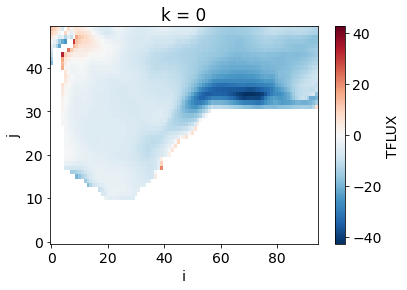

In [37]:
ds_wg.TFLUX.mean(dim='time').where(mask).plot()

In [46]:
heat_flux = ds_wg.TFLUX.where(mask)
heat_flux.load()

<xarray.DataArray 'TFLUX' (time: 288, j: 50, i: 95)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [ 90.79456   ,  77.96946   ,  65.490036  , ...,  87.208725  ,
          86.38823   ,  86.99164   ],
        [101.13143   ,  92.11824   ,  81.88107   , ...,  94.821     ,
          93.73528   ,  93.6231    ],
        [108.555756  , 101.12008   ,  91.92593   , ...,  95.79296   ,
          94.687004  ,  94.11241   ]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
...
        [ 53.826534  ,  37.37913   ,  18.9691    , ...,  -0.5526386 ,
          -0.2786405 ,   0.95476663],
        [ 85.25919   ,  67.18137   ,  48.048626  , ...,   3.7636745 ,
           4.816965  ,   6.6453485 ],
        [104.43991   ,  96.341545  ,  74.06023   , ...,   5.8029437 ,
           7.2984676 ,   9.4490795 ]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [157.01521   , 160.5386    , 160.87712   , ..., 116.2859    ,
         113.126     , 111.77244   ],
        [156.34496   , 159.1058    , 161.53285   , ..., 124.73876   ,
         124.55168   , 127.55686   ],
        [157.04591   , 158.32336   , 157.0557    , ..., 126.85184   ,
         127.492     , 130.24353   ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    k        int64 0
Dimensions without coordinates: j, i
Attributes:
    long_name:      total heat flux (match heat-content variations), >0 incre...
    standard_name:  TFLUX
    units:          W/m^2

In [39]:
heat_flx_anom = ds_wg.TFLUX.where(mask).groupby('time.month') - ds_wg.TFLUX.where(mask).groupby('time.month').mean()
heat_flx_anom

<xarray.DataArray 'TFLUX' (time: 288, j: 50, i: 95)>
dask.array<getitem, shape=(288, 50, 95), dtype=float32, chunksize=(1, 50, 67), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    k        int64 0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: j, i

/srv/conda/envs/notebook/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


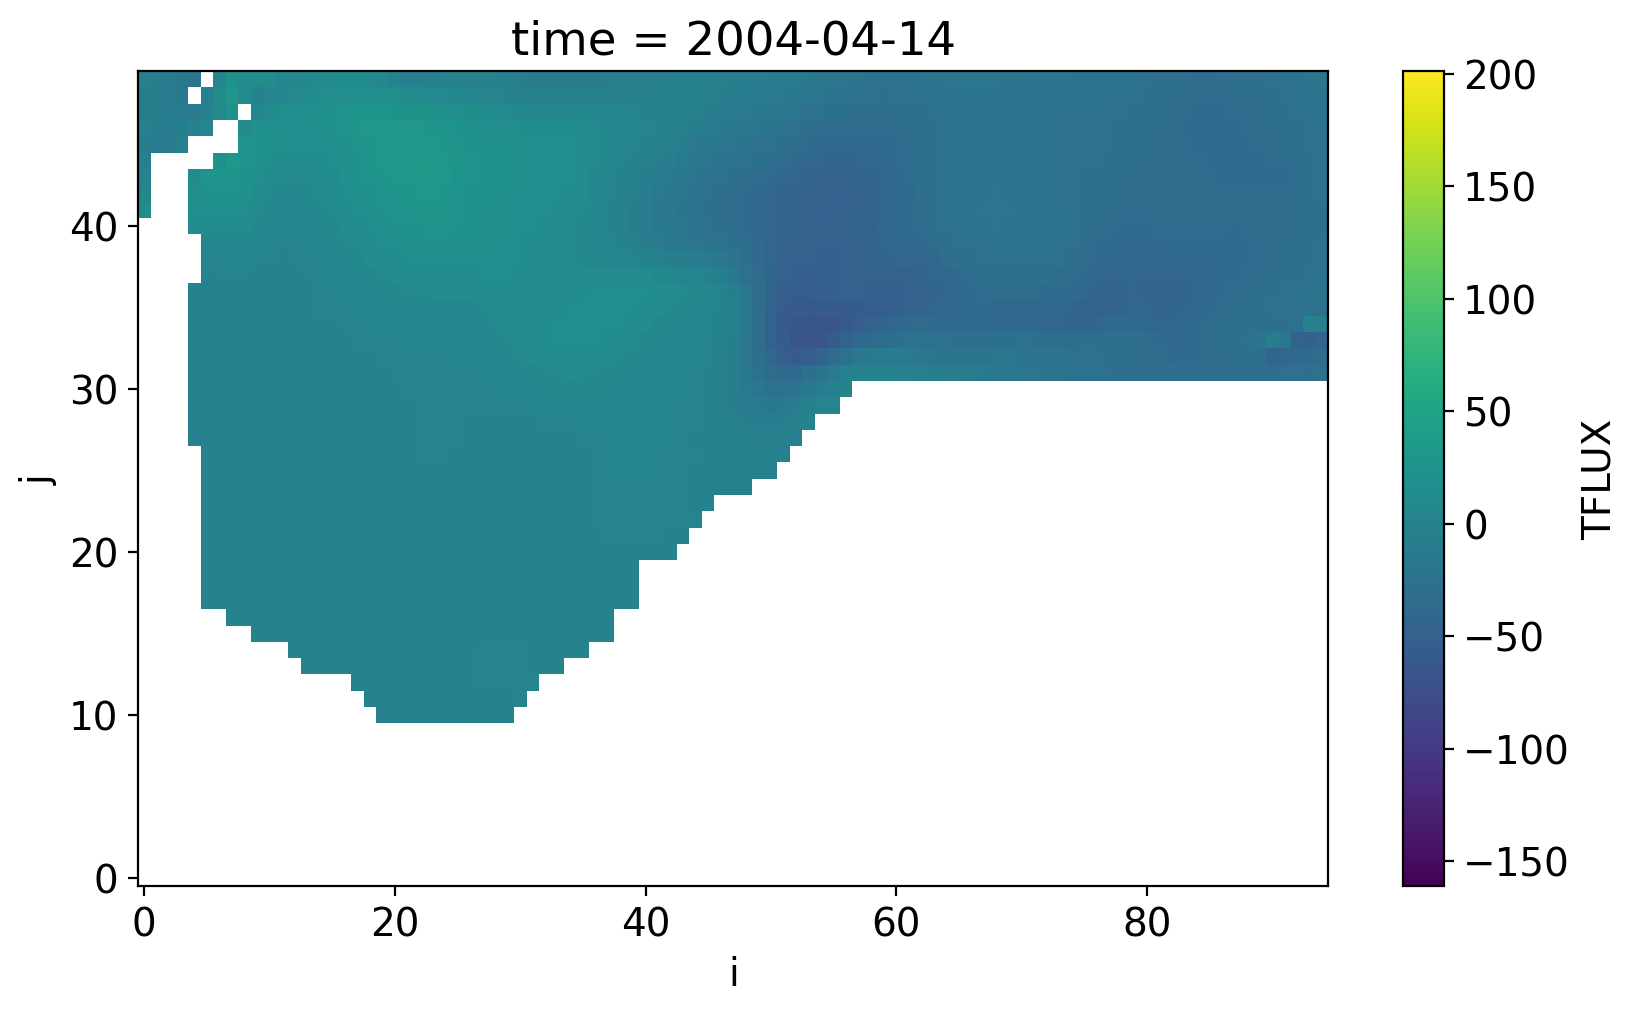

In [43]:
mov_anom = Movie(heat_flx_anom.drop(('month', 'k')).sel(time=slice('2004', '2008')))
mov_anom.preview(3)

In [50]:
mov1 = Movie(heat_flux.sel(time=slice('2004', '2008')))

/srv/conda/envs/notebook/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


In [44]:
#save surf heat flux movie
mov_anom.save('surf_heat_flx_anom_ECCO.mp4', progress=True)

  0%|          | 0/60 [00:00<?, ?it/s]

Movie created at surf_heat_flx_anom_ECCO.mp4


In [51]:
#save surf heat flux movie
mov1.save('surf_heat_flux_non3D_ECCO.mp4', progress=True)

  0%|          | 0/60 [00:00<?, ?it/s]

Movie created at surf_heat_flux_non3D_ECCO.mp4
